In [5]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns 
sns.set()
%matplotlib inline
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import seaborn as sns
sns.set()
pd.options.mode.chained_assignment = None  # default='warn'

from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
#Read in the cleansed and winsorised data
df = pd.read_csv('/data/workspace_files/cleaned.csv', parse_dates =["eom"])
df.head()

,permno,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,...,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,date,eom,ret_excess
0,10006,71077.250,1.186630,1.408090,-0.189153,9.754357,0.025758,0.434433,-0.019560,0.090720,...,1.956238e-07,0.020151,0.013405,0.474575,0.513313,1.056137e-07,37.0,1959-07-31,1959-07-31,0.064813
1,10014,9723.375,1.687401,2.847321,0.112981,8.221681,0.069418,0.434433,0.048780,0.281250,...,2.040267e-06,0.100000,0.036694,0.520349,0.916624,6.106661e-08,35.0,1959-07-31,1959-07-31,-0.000025
2,10022,21210.000,1.022527,1.045561,0.146052,8.734319,0.041049,0.434433,0.130000,0.217637,...,8.405795e-07,0.052083,0.025663,1.192576,4.492107,2.310417e-08,35.0,1959-07-31,1959-07-31,-0.008954
3,10030,83415.000,1.232348,1.518681,-0.038157,9.981097,0.023733,0.434433,-0.019159,0.196835,...,6.822973e-07,0.029557,0.016014,1.192576,1.285815,9.657306e-08,35.0,1959-07-31,1959-07-31,0.105999
4,10057,30625.000,1.209462,1.462798,0.088590,8.784775,0.030906,0.434433,0.012397,0.186403,...,3.425895e-07,0.055319,0.014424,1.009791,1.615000,1.909091e+00,35.0,1959-07-31,1959-07-31,-0.016352


In [7]:
cols_to_front = ['permno', 'date', 'eom', 'ret_excess']
df = df[cols_to_front + [c for c in df.columns if c not in cols_to_front]]

In [8]:
#Convert to float 32 (format needed for the most ML models)
df[df.columns[3:]] = df[df.columns[3:]].astype('float32')
#Sort observations by date and stock id
df = df.sort_values(by = ['eom', 'permno'], ascending = True)
df.head()

,permno,date,eom,ret_excess,mvel1,beta,betasq,chmom,dolvol,idiovol,...,securedind,sin,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
0,10006,1959-07-31,1959-07-31,0.064813,71077.250,1.186630,1.408090,-0.189153,9.754356,0.025758,...,0.0,0.0,0.013859,1.956238e-07,0.020151,0.013405,0.474575,0.513313,1.056137e-07,37.0
1,10014,1959-07-31,1959-07-31,-0.000025,9723.375,1.687401,2.847321,0.112981,8.221681,0.069418,...,0.0,0.0,0.037710,2.040267e-06,0.100000,0.036694,0.520349,0.916624,6.106661e-08,35.0
2,10022,1959-07-31,1959-07-31,-0.008954,21210.000,1.022527,1.045561,0.146052,8.734319,0.041049,...,0.0,0.0,0.026405,8.405795e-07,0.052083,0.025663,1.192576,4.492107,2.310417e-08,35.0
3,10030,1959-07-31,1959-07-31,0.105999,83415.000,1.232348,1.518681,-0.038157,9.981096,0.023733,...,0.0,0.0,0.016875,6.822973e-07,0.029557,0.016014,1.192576,1.285815,9.657306e-08,35.0
4,10057,1959-07-31,1959-07-31,-0.016352,30625.000,1.209462,1.462798,0.088590,8.784775,0.030906,...,0.0,0.0,0.008054,3.425895e-07,0.055319,0.014424,1.009791,1.615000,1.909091e+00,35.0


In [11]:
# The last year is not uesed since we dont have the lead excess return  "ret_exc_lead1m" for January 2021 and we
# use 1 year for testing
print("Number of months: ", df['eom'].nunique())
print("Start: ", df['eom'].min())
print("End: ", df['eom'].max())

Number of months:  523
Start:  1959-07-31 00:00:00
End:  2021-12-31 00:00:00


In [13]:
#There are 32695 unique german stocks
print("Number of unique stcocks: ", df["permno"].nunique())

Number of unique stcocks:  32695


In [14]:
#Inspect variable types
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845386 entries, 0 to 2845385
Data columns (total 32 columns):
 #   Column      Dtype         
---  ------      -----         
 0   permno      int64         
 1   date        object        
 2   eom         datetime64[ns]
 3   ret_excess  float32       
 4   mvel1       float32       
 5   beta        float32       
 6   betasq      float32       
 7   chmom       float32       
 8   dolvol      float32       
 9   idiovol     float32       
 10  indmom      float32       
 11  mom1m       float32       
 12  mom6m       float32       
 13  mom12m      float32       
 14  mom36m      float32       
 15  pricedelay  float32       
 16  turn        float32       
 17  age         float32       
 18  convind     float32       
 19  ep          float32       
 20  herf        float32       
 21  mve_ia      float32       
 22  securedind  float32       
 23  sin         float32       
 24  baspread    float32       
 25  ill         float3

Minimum number of stocks pre month:  1073
Maximum number of stocks pre month:  9042
Mean number of stocks pre month:  5440.508604206501


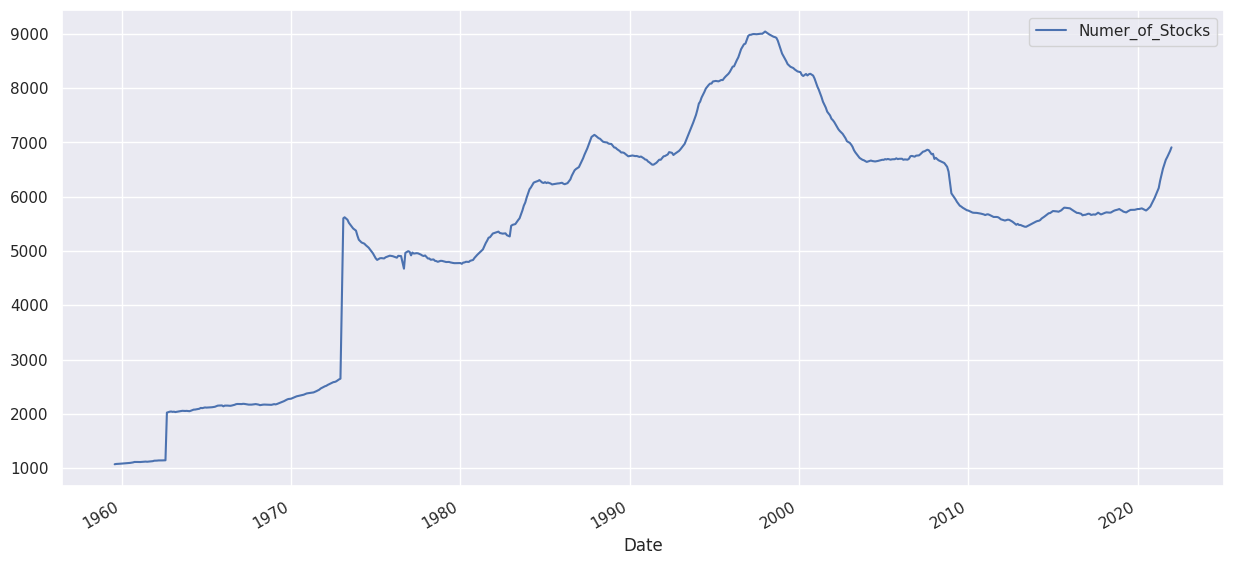

In [15]:
#Number of stocks at each month; 
Number_stocks_per_month = Counter(df['eom'])
Number_stocks_per_month= pd.DataFrame(Number_stocks_per_month.items(), columns=['Date', 'Numer_of_Stocks'])
print("Minimum number of stocks pre month: ", Number_stocks_per_month["Numer_of_Stocks"].min())
print("Maximum number of stocks pre month: ", Number_stocks_per_month["Numer_of_Stocks"].max())
print("Mean number of stocks pre month: ", Number_stocks_per_month["Numer_of_Stocks"].mean())
Number_stocks_per_month.plot(x='Date', y='Numer_of_Stocks',grid=True,figsize=(15, 7));

### Descriptive Statistics of the characteristics

In [16]:
#We are interested in the descriptive statistics of all 49 stock level characteristics and the target variable (ret_exc_lead1m)
features = df.columns[~df.columns.isin(['permno',"date","eom","ret_excess"])].tolist()

In [17]:
descriptive_statistics = df[features].describe()
descriptive_statistics

,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,mom12m,...,securedind,sin,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
count,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,...,2.845386e+06,2845386.0,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06,2.845386e+06
mean,1.234717e+06,1.008622e+00,1.385898e+00,3.618097e-04,1.093202e+01,5.896117e-02,1.232628e-01,7.179052e-03,4.308875e-02,1.012006e-01,...,4.030898e-01,0.0,5.143761e-02,3.401639e-06,6.772631e-02,3.003595e-02,8.435166e-01,3.867546e+00,1.270394e+00,4.726081e+01
std,4.157806e+06,6.024272e-01,1.552539e+00,4.621259e-01,2.877286e+00,3.432386e-02,2.607213e-01,1.354737e-01,3.105224e-01,4.784614e-01,...,4.905186e-01,0.0,5.922884e-02,1.203509e-05,6.415646e-02,2.360699e-02,3.880421e-01,6.866920e+00,3.221002e+00,1.892796e+01
min,1.187375e+03,-9.024989e-02,7.041791e-04,-1.463212e+00,4.465908e+00,1.163437e-02,-4.236139e-01,-3.516814e-01,-6.440722e-01,-7.878788e-01,...,0.000000e+00,0.0,5.225863e-03,1.967953e-11,0.000000e+00,1.102080e-03,2.446926e-01,7.340747e-02,2.225267e-09,1.000000e+01
25%,2.272291e+04,5.981041e-01,3.634173e-01,-2.202797e-01,8.902711e+00,3.513638e-02,-4.139913e-02,-6.034483e-02,-1.271428e-01,-1.751748e-01,...,0.000000e+00,0.0,1.929464e-02,8.996408e-09,2.706849e-02,1.422493e-02,5.401114e-01,7.462699e-01,1.976917e-08,3.500000e+01
50%,1.006875e+05,9.553817e-01,9.175167e-01,-7.256706e-03,1.063723e+01,5.110424e-02,1.030390e-01,0.000000e+00,2.158300e-02,5.263158e-02,...,0.000000e+00,0.0,3.267226e-02,1.373629e-07,4.761905e-02,2.323446e-02,8.032805e-01,1.595631e+00,5.886665e-08,4.800000e+01
75%,5.062585e+05,1.334024e+00,1.783674e+00,2.135670e-01,1.292367e+01,7.313496e-02,2.517472e-01,6.403947e-02,1.725666e-01,2.793523e-01,...,1.000000e+00,0.0,5.833049e-02,1.036455e-06,8.405796e-02,3.797410e-02,1.068186e+00,3.826935e+00,3.037504e-07,6.300000e+01
max,3.135684e+07,2.858352e+00,8.195693e+00,1.512247e+00,1.765395e+01,1.861376e-01,1.082858e+00,4.893617e-01,1.222222e+00,2.065795e+00,...,1.000000e+00,0.0,3.855700e-01,8.892250e-05,3.584906e-01,1.295709e-01,2.015922e+00,4.694465e+01,1.600000e+01,8.700000e+01


In [20]:
descriptive_statistics.to_csv('descriptive_statistics.csv')

### Distribution of each feature

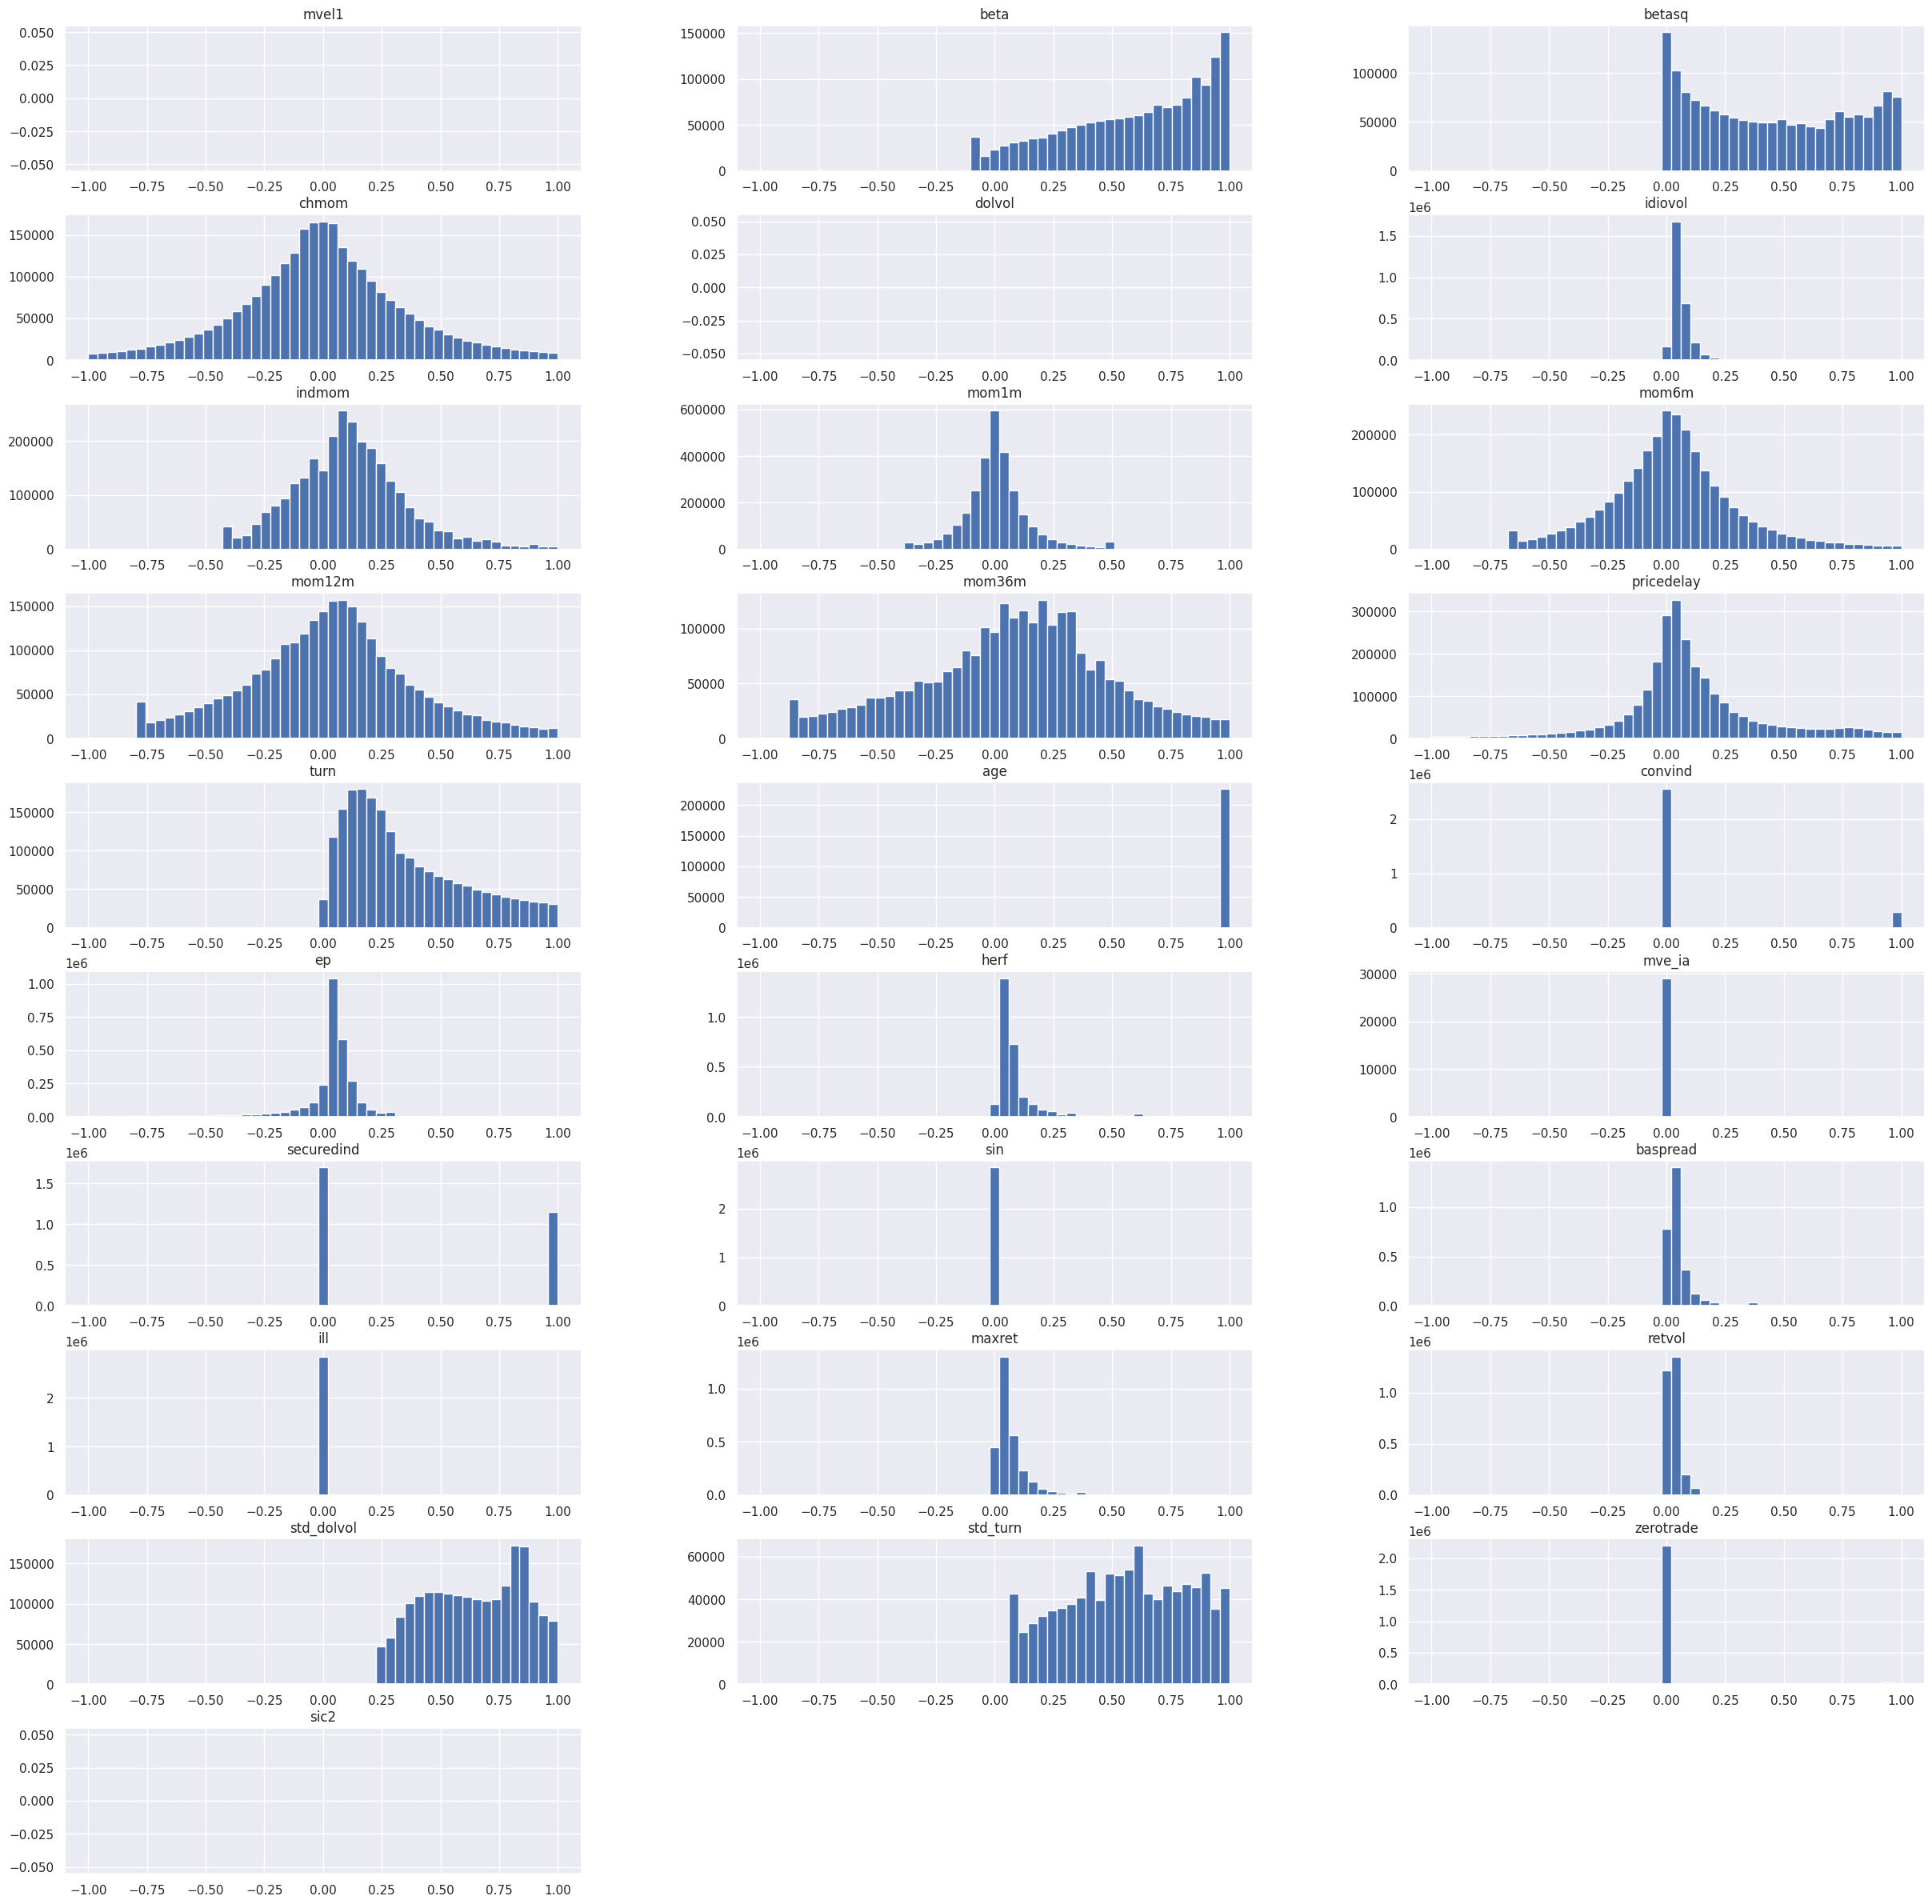

In [21]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
df[features].hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax)

### Distribution of portfolio returns

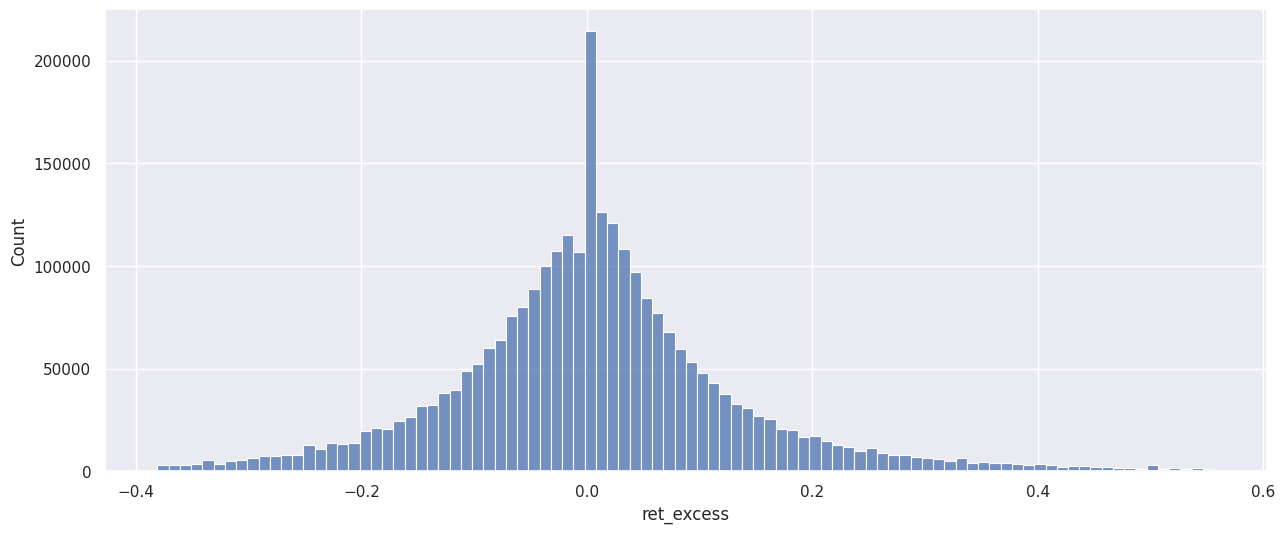

In [23]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
df_3 = df[["ret_excess"]]
sns.histplot(data = df_3, x ="ret_excess", binwidth = 0.01, binrange = (df_3["ret_excess"].min()+ 0.00000000001, df_3["ret_excess"].max()- 0.01))
plt.savefig('returns_distrubution.png')

### Equally weighted portfolio monthly returns over time

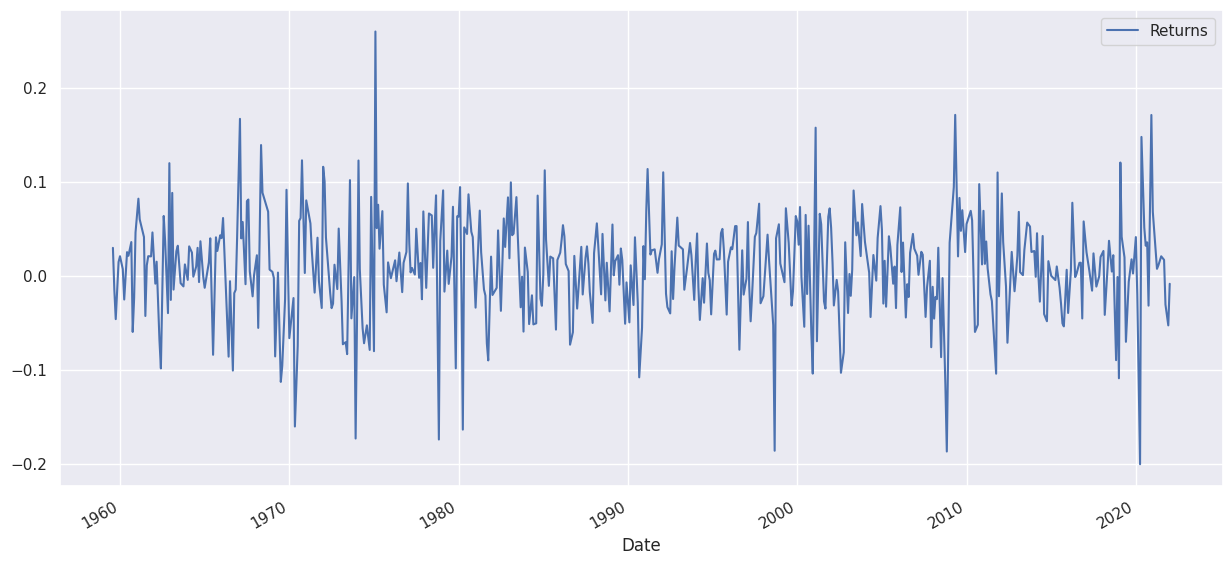

In [26]:
#retain only return data over time
ret_data = df[["ret_excess", "permno", "eom"]]
#create equal weights
ret_data["eq_weights"] = 1/ret_data.groupby('eom')["permno"].transform('size')
#calculate montly return of the equally weighted portfolio contaning all stocks
ret_data['return_stock_ew'] = ret_data["ret_excess"]*ret_data["eq_weights"]
ret_data['Returns'] = ret_data.groupby('eom')["return_stock_ew"].transform('sum')
#drop duplicates 
ret_data = ret_data[["eom", "Returns"]].drop_duplicates()
#rename eon (end of month) to "date"
ret_data = ret_data.rename(columns={'eom': 'Date'})
ret_data = ret_data.set_index("Date")
#plot the portfolio returns over time
ret_data.plot(grid=True,figsize=(15, 7))
#save grapgh
plt.savefig('portfolio monthly returns over time.png')

### Portfolio autocorrelation graph

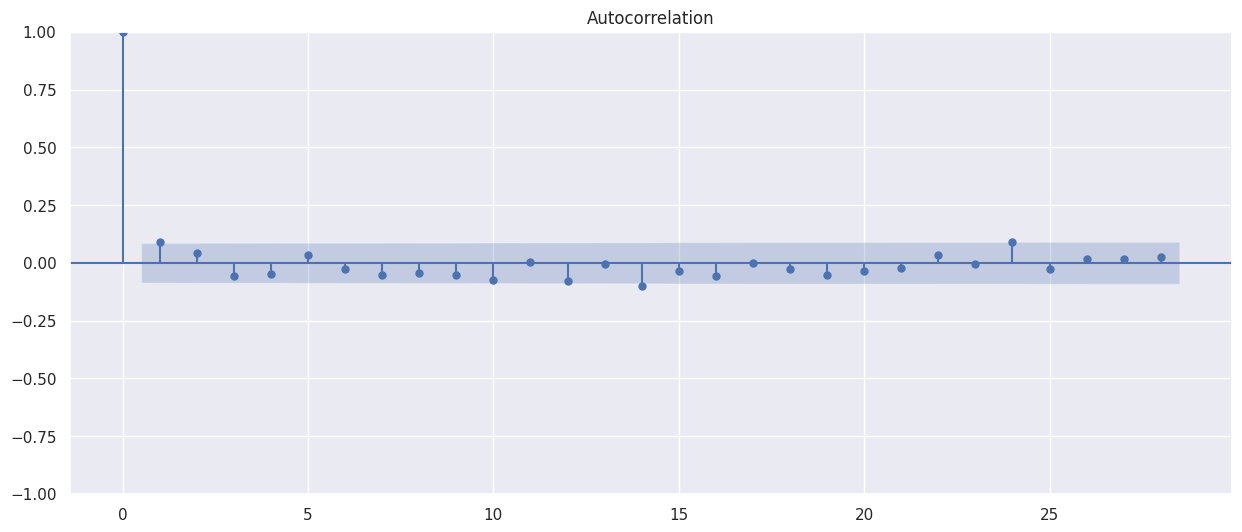

<Figure size 1500x600 with 0 Axes>

In [27]:
plot_acf(ret_data)
# Show the data as a plot (via matplotlib)
plt.show()
plt.savefig('Portfolio autocorrelation graph.png')

## Variable Correlation Heatmap

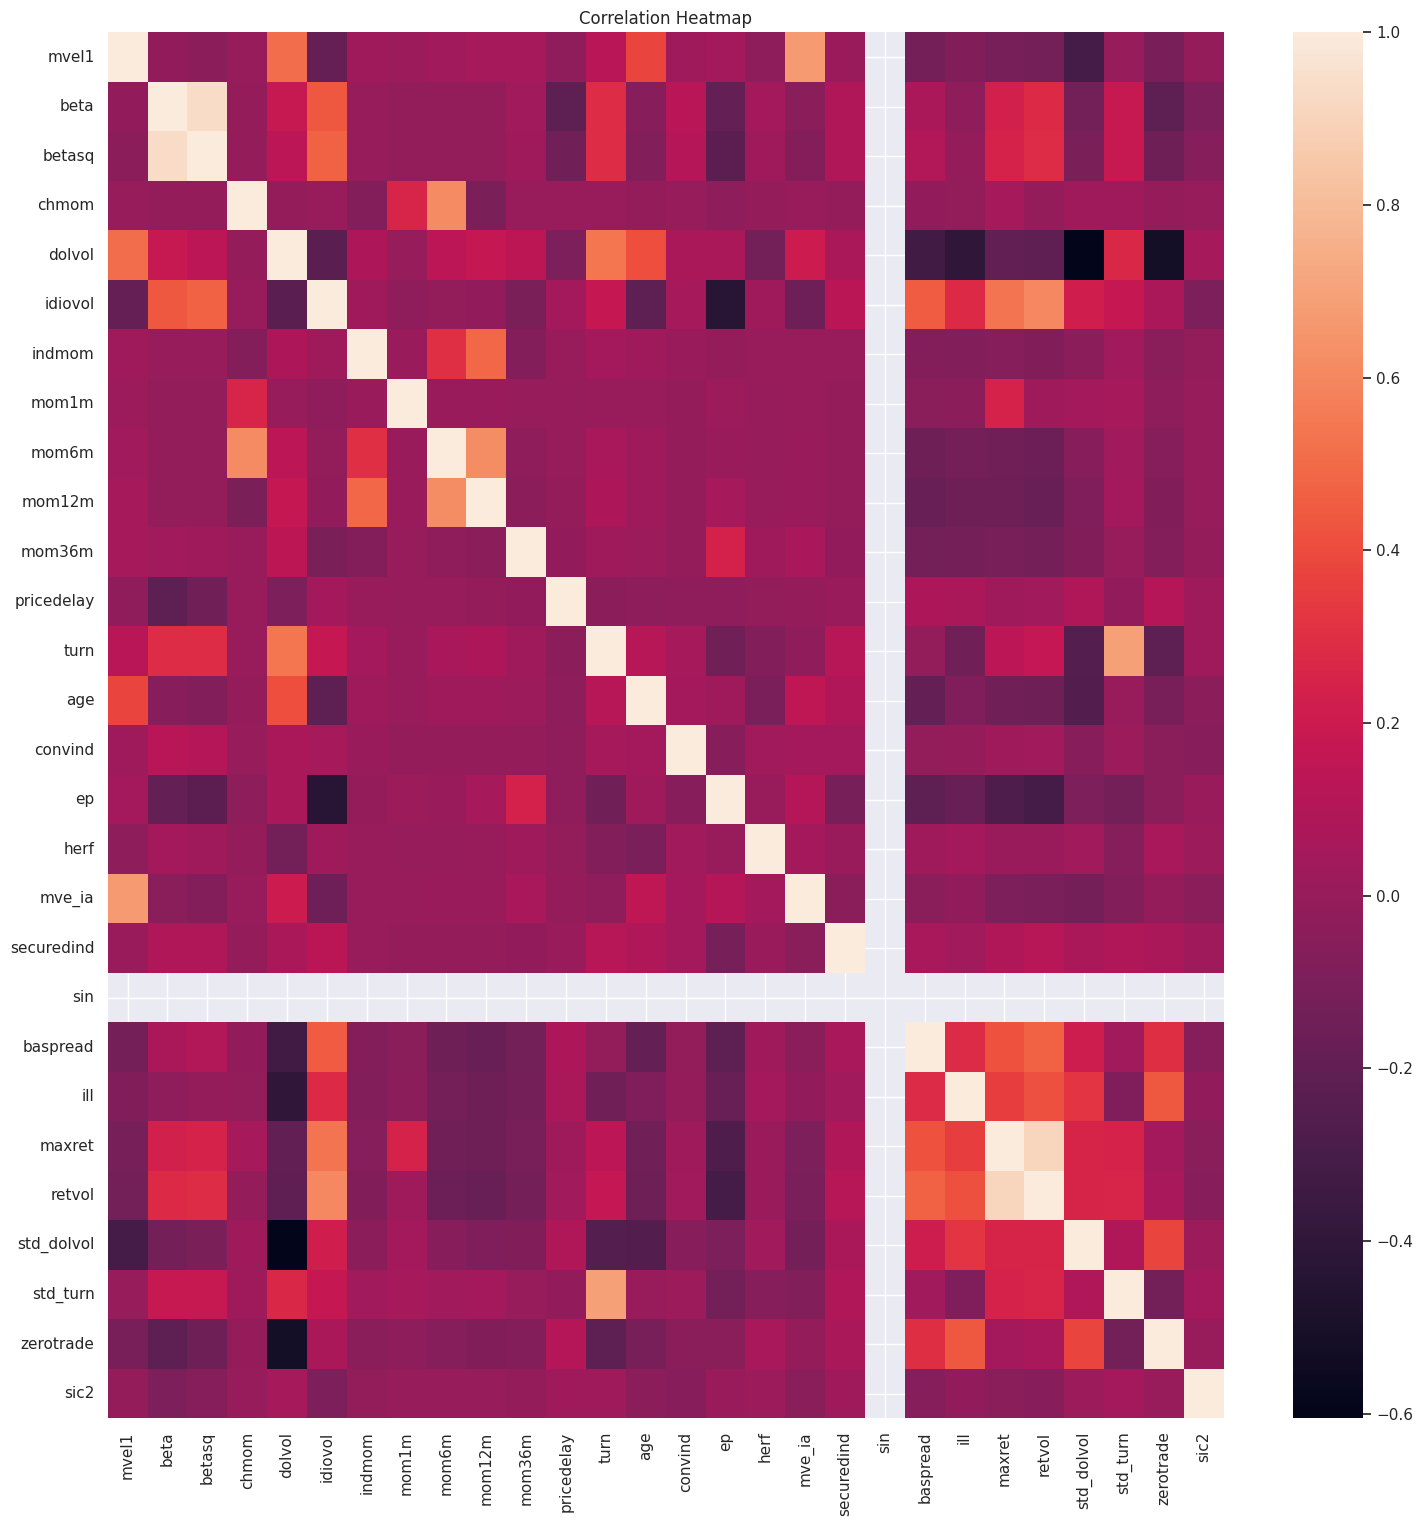

<Figure size 1500x600 with 0 Axes>

In [28]:
features = df.columns[~df.columns.isin(['permno',"eom","ret_excess","date"])].tolist()
plt.figure(figsize = (18,18))
sns.heatmap(data=df[features].corr())
plt.title('Correlation Heatmap')
plt.savefig('Correlation Heatmap.png')
plt.show()
plt.gcf().clear()

## Top Correlated Features (Pearson’s correlation)

In [29]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
c = df[features].corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort").reset_index()
so.columns = ['Variable 1','Variable 2', 'corr']
so = so.sort_values(by = ['corr', 'Variable 1'], ascending = False)
so = so[so['corr']!=1]
so = so.iloc[::2].reset_index(drop=True)
so

,Variable 1,Variable 2,corr
0,betasq,beta,0.936519
1,retvol,maxret,0.908896
2,turn,std_turn,0.687214
3,mvel1,mve_ia,0.668219
4,mom6m,mom12m,0.621658
5,mom6m,chmom,0.614774
6,std_dolvol,dolvol,0.605173
7,retvol,idiovol,0.599930
8,turn,dolvol,0.537969
9,maxret,idiovol,0.530477


In [31]:
so.to_csv('variable_correlation.csv')